In [94]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [95]:
miRNA_dataset = "../../datasets/preprocessed/clinical_miRNA.csv"
gene_names = "../../datasets/preprocessed/genes_names.txt"

In [96]:
data = pd.read_csv(miRNA_dataset)
print(data.head(2))

   days_to_death pathologic_stage  age_at_initial_pathologic_diagnosis  \
0           -1.0        Stage IIA                                   71   
1           -1.0          Stage I                                   53   

   days_to_last_followup  Death                               case_id  \
0                 1918.0      0  378778d2-b331-4867-a93b-c64028c8b4c7   
1                 1309.0      0  b343bfe0-7c23-4c6a-8c84-9ee39db2ecda   

                                          read_count  
0  [13756, 13807, 13949, 55698, 5797, 518, 3747, ...  
1  [37711, 37303, 37662, 44231, 14405, 1889, 3169...  


In [97]:
# Show columns name
data.columns

Index(['days_to_death', 'pathologic_stage',
       'age_at_initial_pathologic_diagnosis', 'days_to_last_followup', 'Death',
       'case_id', 'read_count'],
      dtype='object')

In [98]:
# Read file TXT with gene names
with open(gene_names, 'r') as f:
    genes = f.read().splitlines()
genes

['hsa-let-7a-1',
 'hsa-let-7a-2',
 'hsa-let-7a-3',
 'hsa-let-7b',
 'hsa-let-7c',
 'hsa-let-7d',
 'hsa-let-7e',
 'hsa-let-7f-1',
 'hsa-let-7f-2',
 'hsa-let-7g',
 'hsa-let-7i',
 'hsa-mir-1-1',
 'hsa-mir-1-2',
 'hsa-mir-100',
 'hsa-mir-101-1',
 'hsa-mir-101-2',
 'hsa-mir-103a-1',
 'hsa-mir-103a-2',
 'hsa-mir-103b-1',
 'hsa-mir-103b-2',
 'hsa-mir-105-1',
 'hsa-mir-105-2',
 'hsa-mir-106a',
 'hsa-mir-106b',
 'hsa-mir-107',
 'hsa-mir-10a',
 'hsa-mir-10b',
 'hsa-mir-1178',
 'hsa-mir-1179',
 'hsa-mir-1180',
 'hsa-mir-1181',
 'hsa-mir-1182',
 'hsa-mir-1183',
 'hsa-mir-1184-1',
 'hsa-mir-1184-2',
 'hsa-mir-1184-3',
 'hsa-mir-1185-1',
 'hsa-mir-1185-2',
 'hsa-mir-1193',
 'hsa-mir-1197',
 'hsa-mir-1199',
 'hsa-mir-1200',
 'hsa-mir-1202',
 'hsa-mir-1203',
 'hsa-mir-1204',
 'hsa-mir-1205',
 'hsa-mir-1206',
 'hsa-mir-1207',
 'hsa-mir-1208',
 'hsa-mir-122',
 'hsa-mir-1224',
 'hsa-mir-1225',
 'hsa-mir-1226',
 'hsa-mir-1227',
 'hsa-mir-1228',
 'hsa-mir-1229',
 'hsa-mir-1231',
 'hsa-mir-1233-1',
 'hsa-mir

## Analisi dell'espressione dei miRNA in pazienti vivi e deceduti

In [99]:
import pandas as pd
import numpy as np
from scipy import stats
import ast

# --- 1️⃣ Funzione per convertire i valori di read_count in liste numeriche ---
def parse_read_count(x):
    if isinstance(x, str):
        try:
            x = ast.literal_eval(x)
        except Exception:
            return []
    return [float(v) for v in x if str(v).replace('.', '', 1).isdigit()]

data["read_count"] = data["read_count"].apply(parse_read_count)

# --- 2️⃣ Assumi di avere una lista di nomi di geni (nell’ordine corretto) ---
# Esempio:
# (Deve avere la stessa lunghezza delle liste in read_count)

# --- 3️⃣ Crea un DataFrame “wide” con i nomi reali dei miRNA come colonne ---
read_count_df = pd.DataFrame(data["read_count"].tolist(), columns=genes)

# --- 4️⃣ Aggiungi i metadati (case_id e Death) ---
df_long = (
    data[["case_id", "Death"]]
    .join(read_count_df)
    .melt(id_vars=["case_id", "Death"], var_name="miRNA_ID", value_name="expression")
)

# --- 5️⃣ Rimuovi valori mancanti ---
df_long = df_long.dropna(subset=["expression"])

# --- 6️⃣ Calcola media e IC per ogni miRNA e stato vitale ---
results = []
for (miRNA, status), group in df_long.groupby(["miRNA_ID", "Death"]):
    mean = group["expression"].mean()
    sem = stats.sem(group["expression"])
    if len(group) > 1:
        ci = stats.t.interval(0.95, len(group)-1, loc=mean, scale=sem)
    else:
        ci = (np.nan, np.nan)
    results.append({
        "miRNA_ID": miRNA,
        "Death": status,
        "mean": mean,
        "ci_low": ci[0],
        "ci_high": ci[1]
    })

results_df = pd.DataFrame(results)

# --- 7️⃣ Visualizza i primi risultati ---
print(results_df.head(10))

c:\users\giorg\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\giorg\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


       miRNA_ID  Death          mean        ci_low       ci_high
0  hsa-let-7a-1      0  34132.377522  31457.608610  36807.146433
1  hsa-let-7a-1      1  27925.698630  19651.456178  36199.941083
2  hsa-let-7a-2      0  34045.557637  31374.070040  36717.045234
3  hsa-let-7a-2      1  27843.424658  19570.950326  36115.898989
4  hsa-let-7a-3      0  34320.482709  31633.842256  37007.123162
5  hsa-let-7a-3      1  28083.986301  19815.906080  36352.066523
6    hsa-let-7b      0  82119.128242  76464.527732  87773.728752
7    hsa-let-7b      1  65736.136986  47230.665663  84241.608310
8    hsa-let-7c      0   6777.507205   6236.466045   7318.548364
9    hsa-let-7c      1   9878.164384   3820.449047  15935.879720


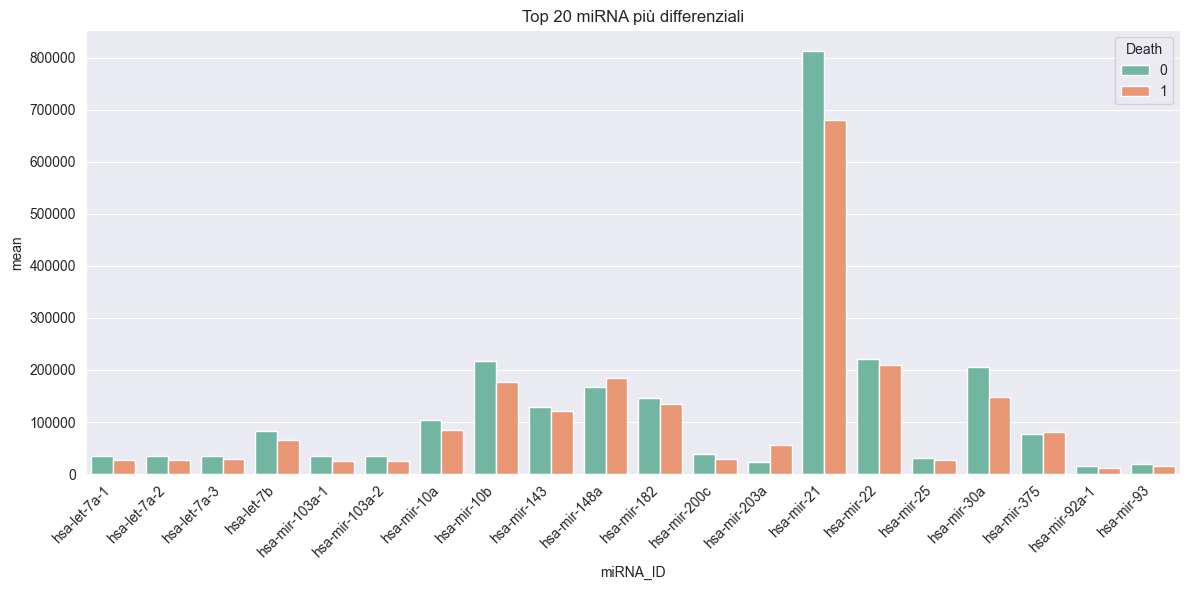

In [100]:
from scipy.stats import ttest_ind

# Calcolo p-value per ogni miRNA
pvals = []
for miRNA, group in df_long.groupby("miRNA_ID"):
    alive = group[group["Death"]==0]["expression"]
    dead = group[group["Death"]==1]["expression"]
    if len(alive)>1 and len(dead)>1:
        _, p = ttest_ind(alive, dead, equal_var=False)
        diff = abs(alive.mean() - dead.mean())
        pvals.append({"miRNA_ID": miRNA, "pval": p, "abs_diff": diff})

pvals_df = pd.DataFrame(pvals)

# Filtra i top 20 miRNA più differenziali
top_miRNA = pvals_df.sort_values("abs_diff", ascending=False).head(20)["miRNA_ID"]

# Plot barre solo per questi
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(
    data=results_df[results_df["miRNA_ID"].isin(top_miRNA)],
    x="miRNA_ID", y="mean", hue="Death",
    palette=["#66c2a5", "#fc8d62"]
)
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 miRNA più differenziali")
plt.tight_layout()
plt.show()


C:\Users\giorg\AppData\Local\Temp\ipykernel_2912\283471445.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


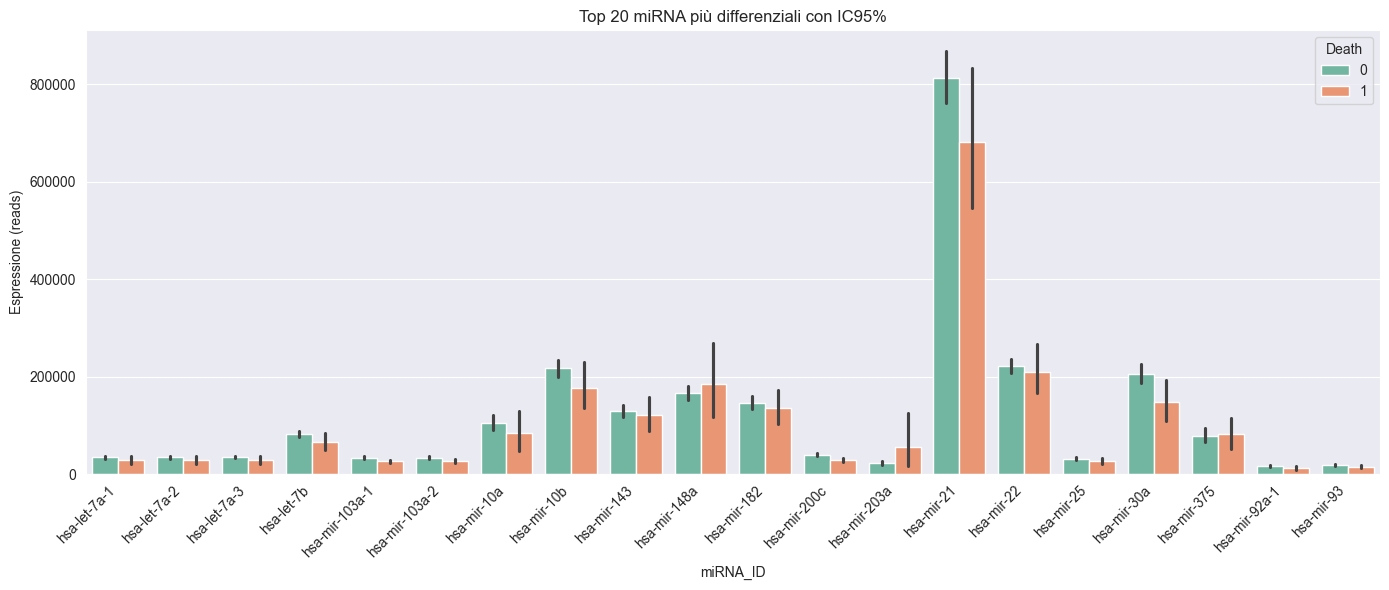

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtra top 20 miRNA più differenziali
top_plot = df_long[df_long["miRNA_ID"].isin(top_miRNA)]

plt.figure(figsize=(14,6))
sns.barplot(
    data=top_plot,
    x="miRNA_ID",
    y="expression",
    hue="Death",
    palette=["#66c2a5", "#fc8d62"],
    ci=95  # Seaborn calcola IC95% automaticamente
)
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 miRNA più differenziali con IC95%")
plt.ylabel("Espressione (reads)")
plt.tight_layout()
plt.show()


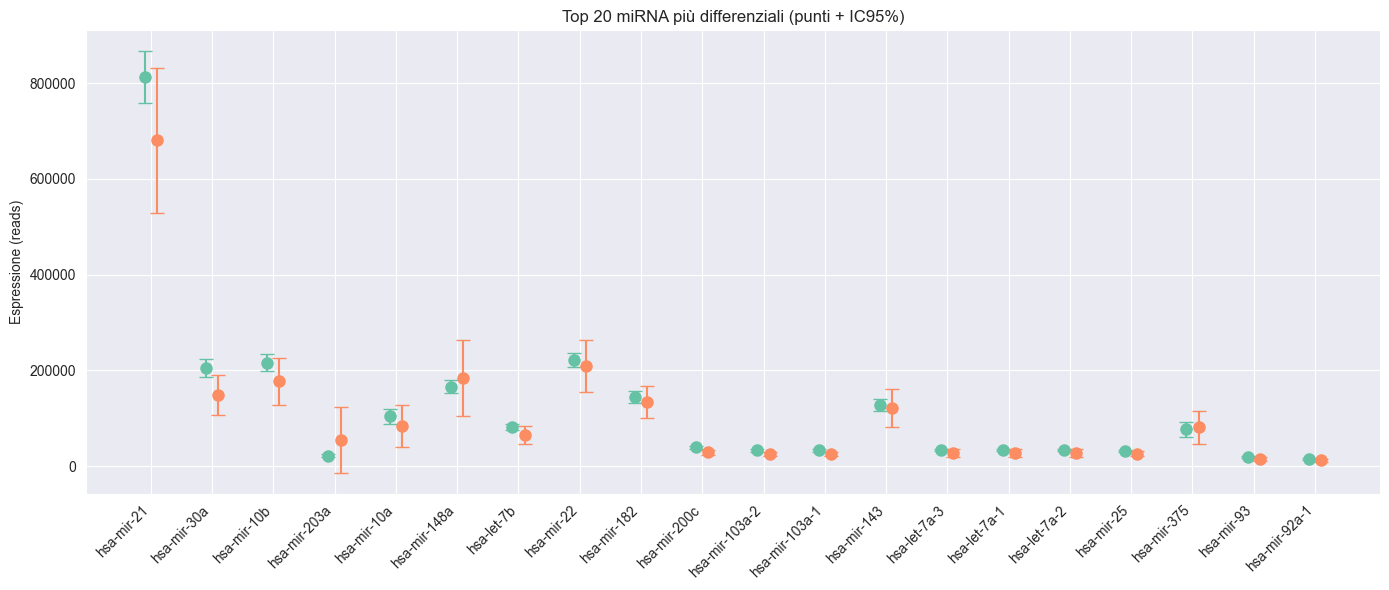

In [102]:
import matplotlib.pyplot as plt
from scipy import stats

plt.figure(figsize=(14,6))

for i, miRNA in enumerate(top_miRNA):
    for j, status in enumerate([0,1]):  # 0=vivi, 1=morti
        group = df_long[(df_long["miRNA_ID"]==miRNA) & (df_long["Death"]==status)]
        mean = group["expression"].mean()
        sem = stats.sem(group["expression"])
        ci_low, ci_high = stats.t.interval(0.95, len(group)-1, loc=mean, scale=sem)
        
        plt.errorbar(
            x=i + (0.1 if status==1 else -0.1),  # spostamento per i gruppi
            y=mean,
            yerr=[[mean-ci_low],[ci_high-mean]],
            fmt='o',
            color="#66c2a5" if status==0 else "#fc8d62",
            capsize=5,
            markersize=8
        )

plt.xticks(range(len(top_miRNA)), top_miRNA, rotation=45, ha="right")
plt.ylabel("Espressione (reads)")
plt.title("Top 20 miRNA più differenziali (punti + IC95%)")
plt.tight_layout()
plt.show()


## Age_at_diagnosis vs miRNA expression

In [103]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Assumiamo che data['read_count'] sia una lista di valori per ciascun miRNA
# e gene_names contenga i nomi reali dei miRNA nello stesso ordine
data['miRNA_ID_list'] = [genes]*len(data)

# Creiamo df_long usando i nomi dei geni
df_long = (
    data[['case_id', 'age_at_initial_pathologic_diagnosis', 'miRNA_ID_list', 'read_count']]
    .explode(['miRNA_ID_list','read_count'])  # "allunga" lista di miRNA e read_count
    .rename(columns={'miRNA_ID_list':'miRNA_ID','read_count':'expression'})
)

# Creiamo gruppi di età
data['age_group'] = pd.qcut(data['age_at_initial_pathologic_diagnosis'], 3, labels=['young','middle','old'])
df_long = df_long.merge(data[['case_id','age_group']], on='case_id')

# Calcolo IC95% della media per ciascun miRNA e gruppo di età
results_age = []
for (miRNA, age_group), group in df_long.groupby(['miRNA_ID','age_group']):
    mean = group['expression'].mean()
    sem = stats.sem(group['expression'])
    if len(group) > 1:
        ci_low, ci_high = stats.t.interval(0.95, len(group)-1, loc=mean, scale=sem)
    else:
        ci_low = ci_high = mean
    results_age.append({
        'miRNA_ID': miRNA,
        'age_group': age_group,
        'mean': mean,
        'ci_low': ci_low,
        'ci_high': ci_high
    })

results_age_df = pd.DataFrame(results_age)
print(results_age_df.head())

C:\Users\giorg\AppData\Local\Temp\ipykernel_2912\4286883024.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (miRNA, age_group), group in df_long.groupby(['miRNA_ID','age_group']):
c:\users\giorg\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\giorg\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


       miRNA_ID age_group          mean        ci_low       ci_high
0  hsa-let-7a-1     young  36435.957746  32310.301920  40561.613573
1  hsa-let-7a-1    middle  33801.441176  29665.219550  37937.662803
2  hsa-let-7a-1       old  30622.518519  25933.345865  35311.691172
3  hsa-let-7a-2     young  36362.285211  32239.619511  40484.950912
4  hsa-let-7a-2    middle  33688.698529  29562.947436  37814.449623


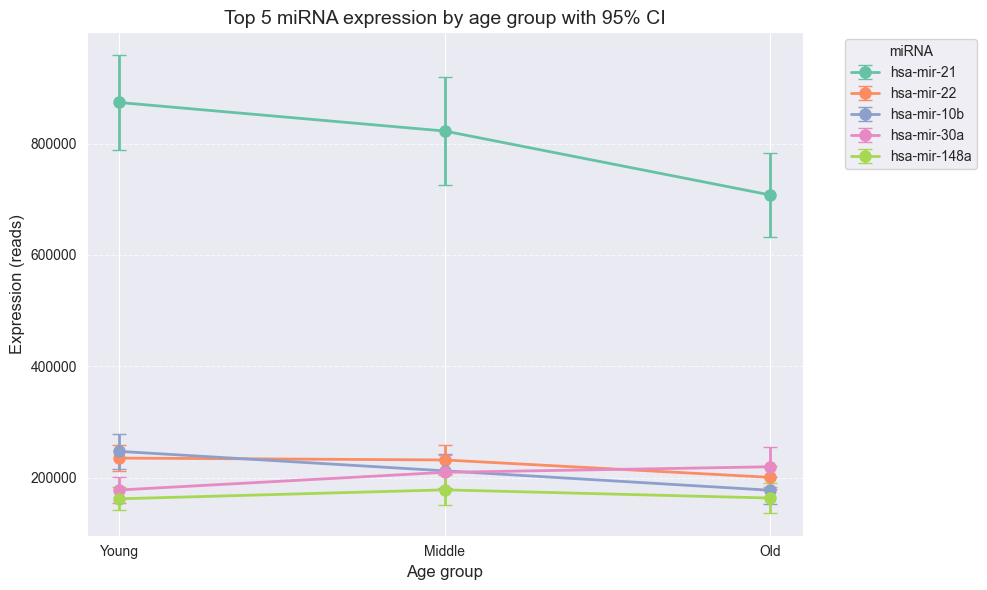

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleziona i top 5 miRNA più espressi
top_miRNA = results_age_df.groupby('miRNA_ID')['mean'].mean().sort_values(ascending=False).head(5).index

plt.figure(figsize=(10,6))

colors = sns.color_palette("Set2", n_colors=len(top_miRNA))  # palette elegante
for i, miRNA in enumerate(top_miRNA):
    df_plot = results_age_df[results_age_df['miRNA_ID']==miRNA]
    plt.errorbar(
        x=np.arange(len(df_plot['age_group'])),
        y=df_plot['mean'],
        yerr=[df_plot['mean']-df_plot['ci_low'], df_plot['ci_high']-df_plot['mean']],
        fmt='o-',  # punti e linee
        color=colors[i],
        capsize=5,
        linewidth=2,
        markersize=8,
        label=miRNA
    )

plt.xticks(np.arange(3), ['Young', 'Middle', 'Old'])
plt.xlabel('Age group', fontsize=12)
plt.ylabel('Expression (reads)', fontsize=12)
plt.title('Top 5 miRNA expression by age group with 95% CI', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='miRNA', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Days_to_death vs miRNA expression